## Overview

In this Project we'll have three ways of simulating stock paths with varying standard deviation being Custom method, Heston Model, and Garch(1,1). We also have or we'll write the corresponding call_price functions of the Heston and garch. Next, We'll compare no hedging, delta-hedging, and delta-vega-hedging. We'll do this process once with simultaing paths from Heston and once from garch. 

In [310]:
#project 4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [311]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% chance the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths

In [312]:
def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu=0.0, n_sims=1):
    """
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - mu (float): Drift component (excess return above r)
    - n_sims (int): Number of simulated paths

    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    """
    dt = t / n_steps
    N1 = np.random.normal(0, 1, size=(n_sims, n_steps))
    N2 = np.random.normal(0, 1, size=(n_sims, n_steps))
    Y = rho * N1 + np.sqrt(1 - rho**2) * N2

    paths = np.zeros((n_sims, n_steps + 1))
    vols = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0
    vols[:, 0] = v0

    for i in range(n_steps):
        vols[:, i + 1] = np.abs(vols[:, i] + kappa * (theta - vols[:, i]) * dt +
                                xi * np.sqrt(np.maximum(vols[:, i], 0) * dt) * N1[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp((mu + r - 0.5 * vols[:, i]) * dt +
                                               np.sqrt(np.maximum(vols[:, i], 0) * dt) * Y[:, i])
    
    return paths, vols

In [313]:
def garch_path_sim(S0, mu, omega, alpha, beta, t=1.0, n_steps=252, n_sims=1, seed=None):
    """
    Simulate stock paths using the GARCH(1,1) model.

    Parameters:
        S0 (float): Initial stock price.
        mu (float): Drift (annualized expected return).
        omega (float): GARCH(1,1) omega parameter.
        alpha (float): GARCH(1,1) alpha parameter (reaction to shocks).
        beta (float): GARCH(1,1) beta parameter (volatility persistence).
        t (float): Total time in years.
        n_steps (int): Number of time steps (e.g. 252 for daily steps in a year).
        n_sims (int): Number of independent simulation paths.
        seed (int): Random seed for reproducibility.

    Returns:
        paths (np.ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1).
        sigmas (np.ndarray): Corresponding volatility paths of shape (n_sims, n_steps).
    """
    if seed is not None:
        np.random.seed(seed)

    dt = t / n_steps
    paths = np.zeros((n_sims, n_steps + 1))
    paths[:, 0] = S0

    returns = np.zeros((n_sims, n_steps))
    sigmas = np.zeros((n_sims, n_steps))

    # Start with unconditional variance estimate
    initial_sigma = np.sqrt(omega / (1 - alpha - beta))
    sigmas[:, 0] = initial_sigma
    epsilons = np.random.randn(n_sims, n_steps)

    for i in range(n_sims):
        for t_idx in range(1, n_steps):
            sigmas[i, t_idx] = np.sqrt(
                omega + alpha * returns[i, t_idx - 1]**2 + beta * sigmas[i, t_idx - 1]**2
            )
            returns[i, t_idx] = mu * dt + sigmas[i, t_idx] * epsilons[i, t_idx]

    # Convert returns to price paths
    log_returns = np.cumsum(returns, axis=1)
    paths[:, 1:] = S0 * np.exp(log_returns)

    return paths, sigmas


In [314]:
def garch_call_price_from_paths(paths, K, r, t):
    """
    Price a European call option using pre-simulated GARCH(1,1) stock price paths.

    Parameters:
        paths (np.ndarray): Simulated stock price paths, shape (n_sims, n_steps + 1)
        K (float): Strike price
        r (float): Risk-free rate
        t (float): Time to maturity (in years)

    Returns:
        call_price (float): Estimated call option price
    """
    if paths.ndim != 2:
        raise ValueError("paths must be a 2D array of shape (n_sims, n_steps + 1)")

    S_T = paths[:, -1]  # terminal prices
    payoffs = np.maximum(S_T - K, 0)
    call_price = np.exp(-r * t) * np.mean(payoffs)
    
    return call_price

In [315]:
# so far we have 3 ways of simulating stock paths with variable std, next we'll look at no hedging, delta-hedging, and vega-hedging and compare the result of each with one another applied to 5000 simulated paths using each method above

In [316]:

S0 = 150 #Initial stock price
v0 = 0.48**2 #Initial variance
K = 190 #Strike Price
r = 0.042#Risk-free interest rate
t = 1#Total time horizon (in years)
n_steps = 252#Number of time steps
kappa = 2.7#Rate of mean reversion of variance
theta = .28**2#Long-run variance
sigma = 0.48 #std
xi = 0.7 #Volatility of volatility
rho = -0.8#Correlation between Brownian motions
n_sims = 5000#
mu = .028#Excess drift of log-returns

paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims)

premium = heston_call(S0, K, v0, r, 0, kappa, theta, xi, rho)
dt = t / n_steps
deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  

## Delta-Vega Hedging

Recall that in delta hedging we adjust our portfolio so the overall delta (sensitivity to the underlying asset’s price moves) is minimized. In vega hedging we also adjust our portfolio so the overall vega (sensitivity to changes in implied volatility) is minimized. combining the two methods will give us protection against both sensitivities. I used the following article "Delta–Vega Hedging with Variance Swaps: How to Reduce Risk and Exposure to Unexpected Shocks" in medium and The Concepts and Practice of Mathematical Finance by Mark S. Joshi(chapter on Hedging with Greeks) and some help for learning about and implementing the method. 



In [317]:
#implement delta hedge
# we will only delta-vega hedge against one helper stock which I'm just making up, in reality we'd have access to many
#and can make an informed decision which to choose but even in my current case the improvement is clear. 

#Call price at time 0 of Stock 1
premium = heston_call(S0, K, v0, r, 0, kappa, theta, xi, rho)

#Parameters for helper Stock
kappa_help = 2
theta_help = 0.3**2 
xi_help = .3
v0_help= .07**2
sigma_help = 9
rho_help = -0.5
S0_help = S0 
K_help= 207
t_help = 2 
r_help = r
mu_help = mu
n_sims_help = 1

#helper Stock
diff_paths, diff_vols = heston_path_sim(S0_help, v0_help, r_help, t_help, n_steps, kappa_help, theta_help, xi_help, rho_help, mu_help, n_sims_help)
# Delta for original paths
deltas_list = []
for i in range(n_steps):
    S = paths[:, i]
    sigma = np.sqrt(vols[:, i])
    tau = t - i * dt
    delta = bs_call_delta(S, K, sigma, tau, r)
    deltas_list.append(delta)
deltas = np.array(deltas_list).T

# Delta for diff_paths
deltas_new_list = []
for i in range(n_steps):
    S_new = diff_paths[:, i]
    sigma_new = np.sqrt(diff_vols[:, i])
    tau_new = t_help - i * dt
    delta_new = bs_call_delta(S_new, K, sigma_new, tau_new, r)
    deltas_new_list.append(delta_new)
deltas_new = np.array(deltas_new_list).T

# Vega for original paths
vegas_list = []
for i in range(n_steps):
    S = paths[:, i]
    sigma = np.sqrt(vols[:, i])
    tau = t - i * dt
    vega = bs_vega(S, K, sigma, tau, r)
    vegas_list.append(vega)
vegas = np.array(vegas_list).T

# Vega for diff_paths
vegas_new_list = []
for i in range(n_steps):
    S_new = diff_paths[:, i]
    sigma_new = np.sqrt(diff_vols[:, i])
    tau_new = t_help - i * dt
    vega_new = bs_vega(S_new, K, sigma_new, tau_new, r)
    vegas_new_list.append(vega_new)
vegas_new = np.array(vegas_new_list).T


#Find the call prices for helper Stock at each step
call_prices_fixed = np.zeros((1, n_steps+1))
for i in range(n_sims_diff):
         for j in range(n_steps):
            call_prices_fixed[i, j] = heston_call(diff_paths[i,j], K, diff_vols[i, j], r, t_help - i * dt, kappa, theta, xi, rho)
options_sold =100


#Solve the Delta-Vega system at each step
delta_solutions = np.zeros((n_sims, n_steps))
sols  = np.zeros((n_sims, n_steps))   
for i in range(n_sims):
        for j in range(n_steps):
            a = [[1,deltas_new[0,j]], [0, vegas_new[0,j]]]
            b = [deltas[i,j]*options_sold, vegas[i,j]*options_sold]
            sol = np.linalg.solve(a,b)
            delta_solutions[i,j] = np.round(sol[0], 2)
            sols[i,j] = np.round(sol[1], 2)

#Count profits of stocks and call options and losses from call payouts
stock_profits_steps_delta = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * delta_solutions* np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits_delta = np.sum(stock_profits_steps_delta, axis=1)
bought_call_payout = (call_prices_fixed[:, 1:]-np.exp(r*dt)*call_prices_fixed[:,:-1])*sols*np.exp(-r *np.arange(1,n_steps+1)*dt)
bought_call_profits = np.sum(bought_call_payout, axis = 1)
call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

#Calculate profits
profit = (premium - call_payouts) +stock_profits_delta + bought_call_profits
deltas_only = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T   
stock_profits_steps_delta_only = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas_only * np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits_delta_only = np.sum(stock_profits_steps_delta_only, axis=1)
call_payouts= np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)
call_sold_profits_delta_only = options_sold*(-call_payouts + premium +stock_profits_delta_only)
call_sold_profits_no_hedge =  options_sold*(premium - call_payouts)

max profit for no-hedge method: -1.8769468887980256
min profit for no-hedge method: -20135.92885665923
expected profit for no-hedge method: -890.5019466521208
standard deviation for no-hedge profit: 1934.6073171919697
----------------------------------------------------------------------
max profit for delta-hedge method: 1900.7669858185232
min profit for delta-hedge method: -4448.274944773361
expected profit for delta-hedge method: -672.9901236223889
standard deviation for delta-hedge profit: 1526.6523780629618
----------------------------------------------------------------------
max profit for delta-vega-hedge method: 12868.232288581317
min profit for delta-vega-hedge method: -1071.7661722891341
expected profit for delta-vega-hedge method: 5311.6117691067775
standard deviation for delta-vega-hedge profit: 2126.2952080412906


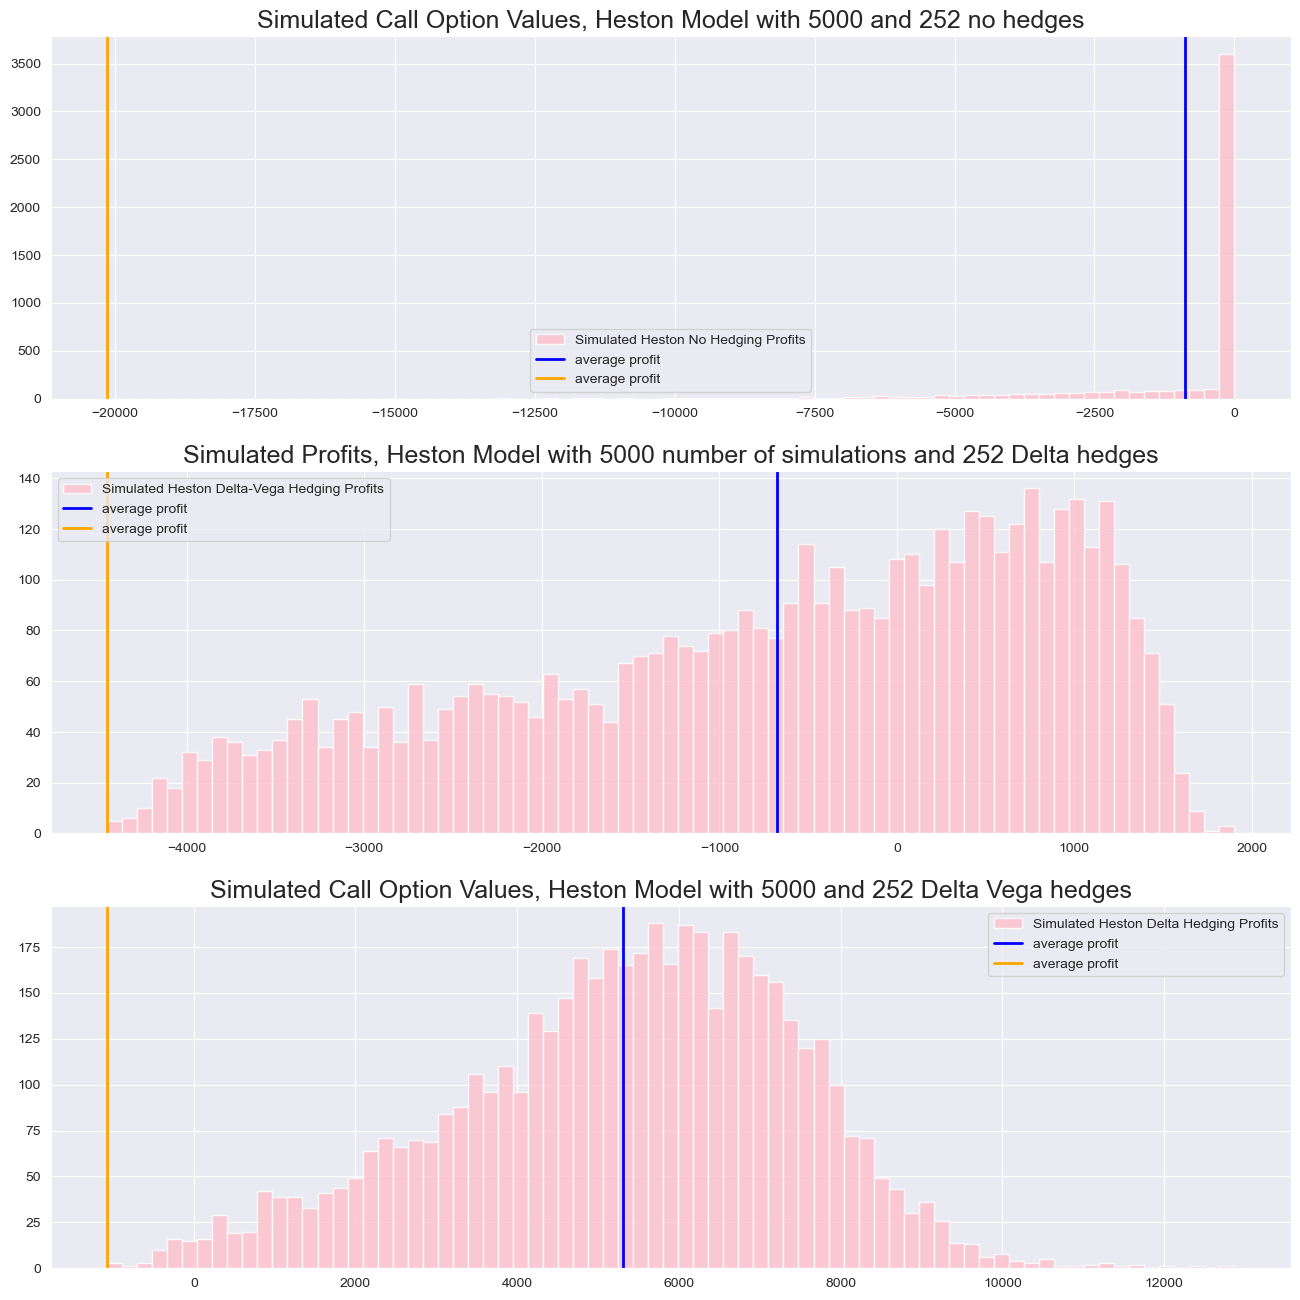

In [318]:

fig, axes = plt.subplots(3,1, figsize = (16,16))
axes[0].hist(call_sold_profits_no_hedge, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston No Hedging Profits')
axes[0].axvline(x = np.mean(call_sold_profits_no_hedge), color  = 'blue', linewidth = 2, label = 'average profit')
axes[0].axvline(x = min(call_sold_profits_no_hedge), color  = 'orange', linewidth = 2, label = 'average profit')
axes[0].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} and {n_steps} no hedges', size = 18)

axes[0].legend()

print(f'max profit for no-hedge method: '+ str(max(call_sold_profits_no_hedge)))
print('min profit for no-hedge method: '+ str(min(call_sold_profits_no_hedge)))
print('expected profit for no-hedge method: ' +str(np.mean(call_sold_profits_no_hedge)))
print(f'standard deviation for no-hedge profit: ' + str(np.std(call_sold_profits_no_hedge)))
print('-------'*10)



axes[1].hist(call_sold_profits_delta_only, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Delta-Vega Hedging Profits')
axes[1].axvline(x = np.mean(call_sold_profits_delta_only), color  = 'blue', linewidth = 2, label = 'average profit')
axes[1].axvline(x = min(call_sold_profits_delta_only), color  = 'orange', linewidth = 2, label = 'average profit')
axes[1].set_title(f'Simulated Profits, Heston Model with {n_sims} number of simulations and {n_steps} Delta hedges', size = 18)
axes[1].legend()

print('max profit for delta-hedge method: '+ str(max(call_sold_profits_delta_only)))
print('min profit for delta-hedge method: '+ str(min(call_sold_profits_delta_only)))
print('expected profit for delta-hedge method: ' +str(np.mean(call_sold_profits_delta_only)))
print('standard deviation for delta-hedge profit: '+ str(np.std(call_sold_profits_delta_only)))
print('-------'*10)

axes[2].hist(profit, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Delta Hedging Profits')
axes[2].axvline(x = np.mean(profit), color  = 'blue', linewidth = 2, label = 'average profit')
axes[2].axvline(x = min(profit), color  = 'orange', linewidth = 2, label = 'average profit')
axes[2].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} and {n_steps} Delta Vega hedges', size = 18)

axes[2].legend()

print('max profit for delta-vega-hedge method: '+ str(max(profit)))
print('min profit for delta-vega-hedge method: '+ str(min(profit)))
print('expected profit for delta-vega-hedge method: ' +str(np.mean(profit)))
print('standard deviation for delta-vega-hedge profit: '+ str(np.std(profit)))
plt.show()

In [319]:
omega=0.000002
alpha=0.1
beta=0.85
seed = 42
paths, vols = garch_path_sim(S0,mu,omega,alpha,beta,t,n_steps,n_sims,seed)
#Call price at time 0 of Stock 1
premium = garch_call_price_from_paths(paths, K, r, t)
dt = t / n_steps
deltas = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T  

#Parameters for helper Stock
kappa_help = 2
theta_help = 0.3**2 
xi_help = .3
v0_help= .07**2
sigma_help = 9
rho_help = -0.5
S0_help = S0 
K_help= 207
t_help = 2 
r_help = r
mu_help = mu
n_sims_help = 1
omega_help=0.000009
alpha_help=0.25
beta_help=0.65
seed_help = 82
#helper stock 
diff_paths, diff_vols = garch_path_sim(S0_help,mu_help,omega_help,alpha_help,beta_help,t_help,n_steps,n_sims_help,seed_diff)

# Delta for original paths
deltas_list = []
for i in range(n_steps):
    S = paths[:, i]
    sigma = np.sqrt(vols[:, i])
    tau = t - i * dt
    delta = bs_call_delta(S, K, sigma, tau, r)
    deltas_list.append(delta)
deltas = np.array(deltas_list).T

# Delta for diff_paths
deltas_new_list = []
for i in range(n_steps):
    S_new = diff_paths[:, i]
    sigma_new = np.sqrt(diff_vols[:, i])
    tau_new = t_help - i * dt
    delta_new = bs_call_delta(S_new, K, sigma_new, tau_new, r)
    deltas_new_list.append(delta_new)
deltas_new = np.array(deltas_new_list).T

# Vega for original paths
vegas_list = []
for i in range(n_steps):
    S = paths[:, i]
    sigma = np.sqrt(vols[:, i])
    tau = t - i * dt
    vega = bs_vega(S, K, sigma, tau, r)
    vegas_list.append(vega)
vegas = np.array(vegas_list).T

# Vega for diff_paths
vegas_new_list = []
for i in range(n_steps):
    S_new = diff_paths[:, i]
    sigma_new = np.sqrt(diff_vols[:, i])
    tau_new = t_help - i * dt
    vega_new = bs_vega(S_new, K, sigma_new, tau_new, r)
    vegas_new_list.append(vega_new)
vegas_new = np.array(vegas_new_list).T


#Find the call prices for helper Stock at each step
call_prices_fixed = np.zeros((1, n_steps+1))
for j in range(n_steps + 1):
    remaining_t = t_help - j * dt
    if remaining_t <= 0:
        call_prices_fixed[0, j] = 0
    else:
        remaining_paths = diff_paths[:, j:] 
        call_prices_fixed[0, j] = garch_call_price_from_paths(remaining_paths, K, r, remaining_t)
options_sold =100


#Solve the Delta-Vega system at each step
delta_solutions = np.zeros((n_sims, n_steps))
sols  = np.zeros((n_sims, n_steps))   
for i in range(n_sims):
        for j in range(n_steps):
            a = [[1,deltas_new[0,j]], [0, vegas_new[0,j]]]
            b = [deltas[i,j]*options_sold, vegas[i,j]*options_sold]
            sol = np.linalg.solve(a,b)
            delta_solutions[i,j] = np.round(sol[0], 2)
            sols[i,j] = np.round(sol[1], 2)

#Count profits of stocks and call options and losses from call payouts
deltas_only = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T   
stock_profits_steps_delta = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * delta_solutions* np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits_delta = np.sum(stock_profits_steps_delta, axis=1)
bought_call_payout = (call_prices_fixed[:, 1:]-np.exp(r*dt)*call_prices_fixed[:,:-1])*sols*np.exp(-r *np.arange(1,n_steps+1)*dt)
bought_call_profits = np.sum(bought_call_payout, axis = 1)
call_payouts = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)

#Calculate profits
profit = (premium - call_payouts) +stock_profits_delta + bought_call_profits

deltas_only = np.array([bs_call_delta(paths[:, i], K, np.sqrt(vols[:,i]), t - i * dt, r) for i in range(n_steps)]).T   
stock_profits_steps_delta_only = (paths[:, 1:] - np.exp(r*dt)*paths[:, :-1]) * deltas_only * np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits_delta_only = np.sum(stock_profits_steps_delta_only, axis=1)
call_payouts= np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)
call_sold_profits_delta_only = options_sold*(-call_payouts + premium +stock_profits_delta_only)
call_sold_profits_no_hedge =  options_sold*(premium - call_payouts)

max profit for no-hedge method: 12.535520803611233
min profit for no-hedge method: -2459.0759420528548
expected profit for no-hedge method: 0.0
standard deviation for no-hedge profit: 125.96678510125292
----------------------------------------------------------------------
max profit for delta-hedge method: 2028.4220212956511
min profit for delta-hedge method: -2456.710163351427
expected profit for delta-hedge method: -100.07159050106902
standard deviation for delta-hedge profit: 798.2596547860562
----------------------------------------------------------------------
max profit for delta-vega-hedge method: 1364.6440591057697
min profit for delta-vega-hedge method: -911.0121855912075
expected profit for delta-vega-hedge method: -29.399050949496157
standard deviation for delta-vega-hedge profit: 287.94176620221396


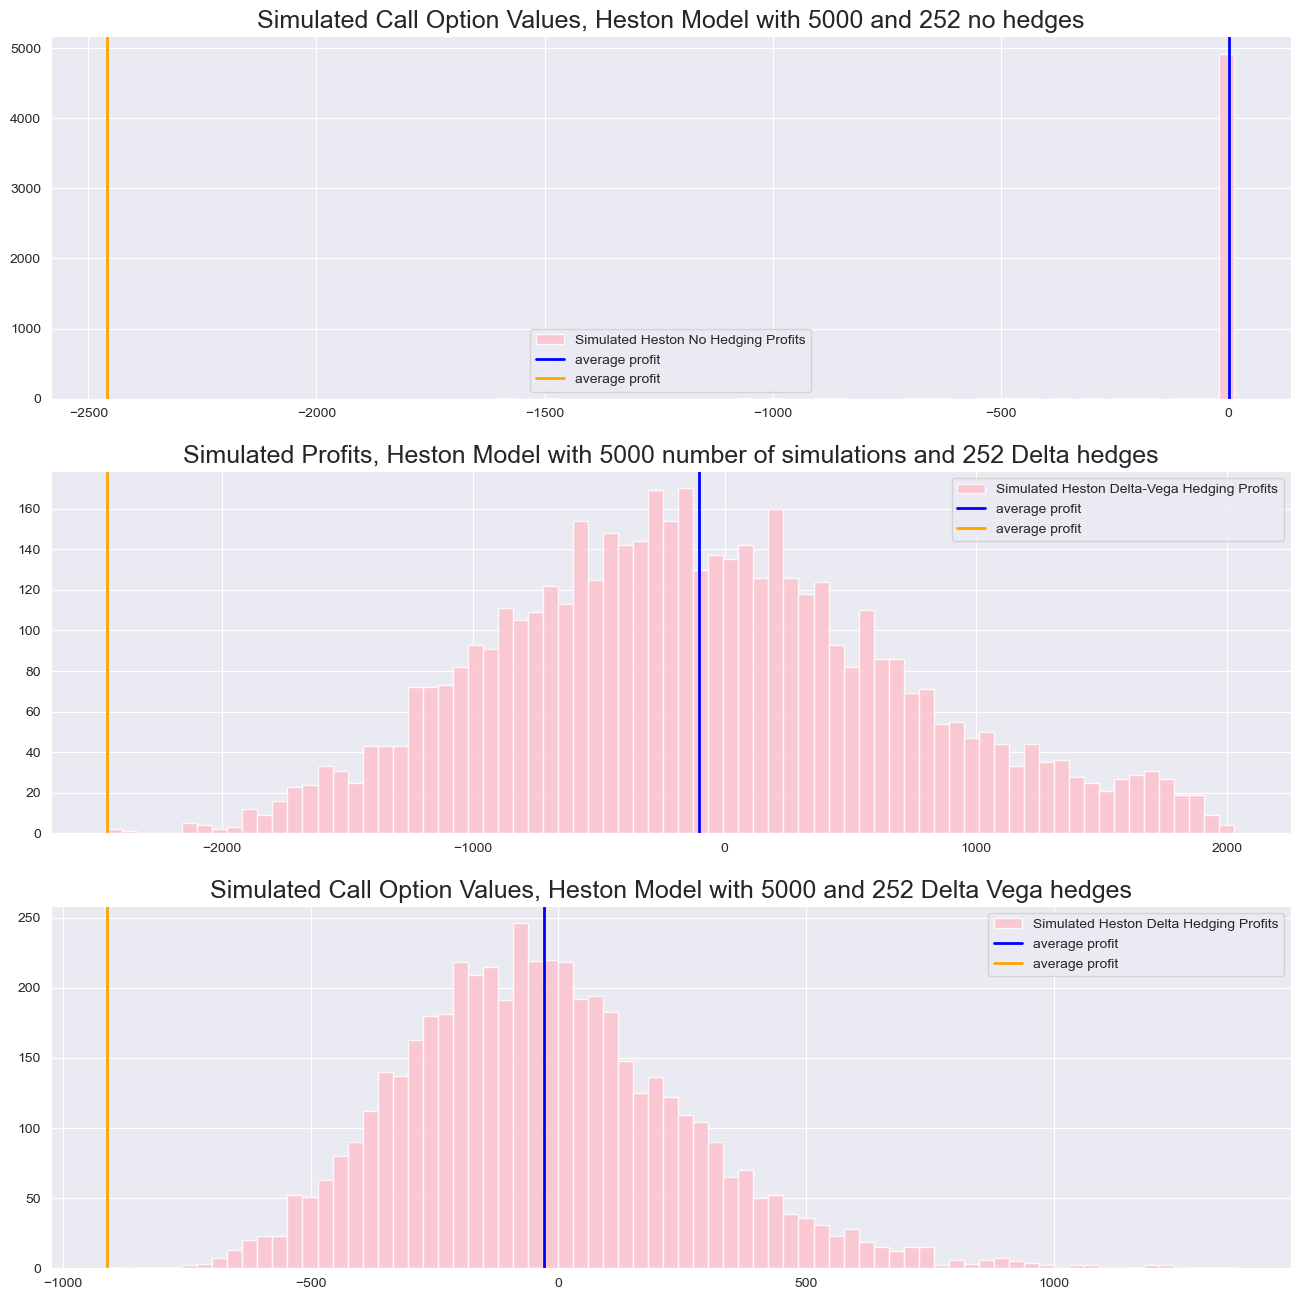

In [320]:
fig, axes = plt.subplots(3,1, figsize = (16,16))
axes[0].hist(call_sold_profits_no_hedge, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston No Hedging Profits')
axes[0].axvline(x = np.mean(call_sold_profits_no_hedge), color  = 'blue', linewidth = 2, label = 'average profit')
axes[0].axvline(x = min(call_sold_profits_no_hedge), color  = 'orange', linewidth = 2, label = 'average profit')
axes[0].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} and {n_steps} no hedges', size = 18)

axes[0].legend()

print('max profit for no-hedge method: '+ str(max(call_sold_profits_no_hedge)))
print('min profit for no-hedge method: '+ str(min(call_sold_profits_no_hedge)))
print('expected profit for no-hedge method: ' +str(np.mean(call_sold_profits_no_hedge)))
print('standard deviation for no-hedge profit: '+ str(np.std(call_sold_profits_no_hedge)))
print('-------'*10)



axes[1].hist(call_sold_profits_delta_only, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Delta-Vega Hedging Profits')
axes[1].axvline(x = np.mean(call_sold_profits_delta_only), color  = 'blue', linewidth = 2, label = 'average profit')
axes[1].axvline(x = min(call_sold_profits_delta_only), color  = 'orange', linewidth = 2, label = 'average profit')
axes[1].set_title(f'Simulated Profits, Heston Model with {n_sims} number of simulations and {n_steps} Delta hedges', size = 18)
axes[1].legend()

print('max profit for delta-hedge method: '+ str(max(call_sold_profits_delta_only)))
print('min profit for delta-hedge method: '+ str(min(call_sold_profits_delta_only)))
print('expected profit for delta-hedge method: ' +str(np.mean(call_sold_profits_delta_only)))
print('standard deviation for delta-hedge profit: '+ str(np.std(call_sold_profits_delta_only)))
print('-------'*10)

axes[2].hist(profit, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Delta Hedging Profits')
axes[2].axvline(x = np.mean(profit), color  = 'blue', linewidth = 2, label = 'average profit')
axes[2].axvline(x = min(profit), color  = 'orange', linewidth = 2, label = 'average profit')
axes[2].set_title(f'Simulated Call Option Values, Heston Model with {n_sims} and {n_steps} Delta Vega hedges', size = 18)

axes[2].legend()
print('max profit for delta-vega-hedge method: '+ str(max(profit)))
print('min profit for delta-vega-hedge method: '+ str(min(profit)))
print('expected profit for delta-vega-hedge method: ' +str(np.mean(profit)))
print('standard deviation for delta-vega-hedge profit: '+ str(np.std(profit)))
plt.show()


## Observation

Delta hedging provides a clear advantage over not hedging at all. However, incorporating Vega hedging alongside Delta hedging further reduces potential losses more effectively. Both the maximum and average profits from Delta-Vega hedging surpass those of Delta hedging alone, making it a more favorable strategy for sellers of call options when volatility varies. That said, the success of Delta-Vega hedging depends on selecting an appropriate hedge asset—such as helper Stock —that complements the characteristics of Stock 1. Additionally, real-world factors can influence the strategy’s effectiveness; for instance, if the market prices of options on helper Stock significantly deviate above theoretical Black-Scholes values, this discrepancy can substantially impact the overall profitability of Delta-Vega hedging.

## Further Improvements

1) I'd like to make the body of my comparison into a function at some point that also takes in the number of simulations and type of path simulator and corresponding variables and prints these results

2) I'd like to more about other types of sigma-hedging and implement those as well.

3) Lastly like previous projects I'd like to learn more and apply some ML models